In [1]:
# default_exp core

# Core Utilities

> Algorithms for computing curvature from graphs using diffusion.

In [2]:
#hide
from nbdev.showdoc import *
import numpy as np
from sklearn.metrics import pairwise_distances
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook will establish our core utilities: functions for building the diffusion matrix, with various types of kernels.

In [3]:
#export
import numpy as np
from sklearn.metrics import pairwise_distances
def DiffusionMatrix(X, kernel_type = "fixed", sigma = 0.7, k = 20, alpha = 0.5, affinity_matrix_only=False):
    """
    Given input12 X returns a diffusion matrix P, as an numpy ndarray.
    X is a numpy array of size n x d
    kernel_type is a string, either "fixed" or "adaptive" or "anisotropic" or "adaptive anisotropic"
    sigma is the non-adaptive gaussian kernel parameter
    k is the adaptive kernel parameter
    Returns:
    P is a numpy array of size n x n that is the diffusion matrix
    """
    # construct the distance matrix
    D = pairwise_distances(X)
    # make the affinity matrix
    if kernel_type == "fixed":
        W = (1/sigma*np.sqrt(2*np.pi))*np.exp(-D**2/(2*sigma**2))
    elif kernel_type == "adaptive" or kernel_type == "adaptive anisotropic":
        # Get the distance to the kth neighbor
        distance_to_k_neighbor = np.partition(D,k)[:,k]
        # Populate matrices with this distance for easy division. 
        div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
        div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
        # print("Distance to kth neighbors",distance_to_k_neighbor)
        # compute the gaussian kernel with an adaptive bandwidth
        W = (1/2*np.sqrt(2*np.pi))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
        if kernel_type == "adaptive anisotropic":
            # Additional normalization step for density
            D = np.diag(1/np.sum(W,axis=1)) 
            W = D @ W @ D
    elif kernel_type == "nearest neighbor":
        pass
    elif kernel_type == "anisotropic":
        W1 = np.exp(-D**2/(2*sigma**2))
        D = np.diag(1/np.sum(W1,axis=1)) 
        W = D @ W1 @ D
    elif kernel_type == "alpha-decay":
        distance_to_k_neighbor = tf.nn.top_k(D, k = k, sorted = True).values[:,-1]
        distance_to_k_neighbor = tf.cast(distance_to_k_neighbor,tf.float32)
        D = tf.cast(D, tf.float32)
        div1 = tf.linalg.matmul(tf.ones(len(D))[:,None], distance_to_k_neighbor[None,:])
        div2 = tf.linalg.matmul(distance_to_k_neighbor[:,None],tf.ones(len(D))[None,:])
        W = 0.5*(tf.exp(-(D/div1)**alpha) + tf.exp(-(D/div2)**alpha))
    else:
        raise ValueError("kernel_type must be either 'fixed' or 'adaptive'")  
    if affinity_matrix_only:
        return W
    # turn affinity matrix into diffusion matrix
    D = np.diag(1/np.sum(W,axis=1))
    P = D @ W
    return P

In [4]:
show_doc(DiffusionMatrix)

<h4 id="DiffusionMatrix" class="doc_header"><code>DiffusionMatrix</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>DiffusionMatrix</code>(**`X`**, **`kernel_type`**=*`'fixed'`*, **`sigma`**=*`0.7`*, **`k`**=*`20`*, **`alpha`**=*`0.5`*, **`nn`**=*`5`*, **`affinity_matrix_only`**=*`False`*)

Given input X returns a diffusion matrix P, as an numpy ndarray.
X is a numpy array of size n x d
kernel_type is a string, either "fixed" or "adaptive" or "anisotropic" or "adaptive anisotropic"
sigma is the non-adaptive gaussian kernel parameter
k is the adaptive kernel parameter
Returns:
P is a numpy array of size n x n that is the diffusion matrix

## Exploration of different kernel functions

In [5]:
X = np.random.rand(5,5)
D = pairwise_distances(X)
D

array([[0.        , 0.87873416, 0.75068172, 0.76419833, 0.81296127],
       [0.87873416, 0.        , 1.05086182, 0.85256909, 0.83893702],
       [0.75068172, 1.05086182, 0.        , 0.8425467 , 1.38537463],
       [0.76419833, 0.85256909, 0.8425467 , 0.        , 0.84807133],
       [0.81296127, 0.83893702, 1.38537463, 0.84807133, 0.        ]])

In [6]:
# Get the distance to the kth closest neighbor
distance_to_k_neighbor = np.partition(D,2)[:,2] # argpartition is more efficient than argsort ([python - How to get indices of top-K values from a numpy array - Stack Overflow](https://stackoverflow.com/questions/65038206/how-to-get-indices-of-top-k-values-from-a-numpy-array))
distance_to_k_neighbor

array([0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702])

Double checking that the code for the adaptive kernel works as intended:

In [7]:
div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
div2

array([[0.76419833, 0.76419833, 0.76419833, 0.76419833, 0.76419833],
       [0.85256909, 0.85256909, 0.85256909, 0.85256909, 0.85256909],
       [0.8425467 , 0.8425467 , 0.8425467 , 0.8425467 , 0.8425467 ],
       [0.8425467 , 0.8425467 , 0.8425467 , 0.8425467 , 0.8425467 ],
       [0.83893702, 0.83893702, 0.83893702, 0.83893702, 0.83893702]])

In [8]:
div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
div1

array([[0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702],
       [0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702],
       [0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702],
       [0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702],
       [0.76419833, 0.85256909, 0.8425467 , 0.8425467 , 0.83893702]])

Let's chart the torus with several different diffusion kernels.

In [9]:
from diffusion_curvature import datasets

In [15]:
X, ks = datasets.torus(n=2000)

In [16]:
X

array([[-0.20090535, -2.11554133, -0.99214924],
       [-0.01682597, -1.60325322, -0.91796626],
       [-2.7333967 , -0.76061527, -0.5468188 ],
       ...,
       [ 1.47478934, -2.11602535, -0.81514494],
       [ 2.04013757,  1.72837183,  0.73887556],
       [-2.964506  , -0.03387417,  0.26335304]])

To visualize this, we'll build a 3D plot helper, to save time in the future

In [39]:
#export
# For plotting 2D and 3D graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_3d(X,distribution=None, title="",lim=None,use_plotly=False,colorbar = False, cmap="plasma"):
    if distribution is None:
        distribution = np.zeros(len(X))
    if lim is None:
        lim = np.max(np.linalg.norm(X,axis=1))
    if use_plotly:
        d = {'x':X[:,0],'y':X[:,1],'z':X[:,2],'colors':distribution}
        df = pd.DataFrame(data=d)
        fig = px.scatter_3d(df, x='x',y='y',z='z',color='colors', title=title, range_x=[-lim,lim], range_y=[-lim,lim],range_z=[-lim,lim])
        fig.show()
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        ax.axes.set_xlim3d(left=-lim, right=lim)
        ax.axes.set_ylim3d(bottom=-lim, top=lim)
        ax.axes.set_zlim3d(bottom=-lim, top=lim)
        im = ax.scatter(X[:,0],X[:,1],X[:,2],c=distribution,cmap=cmap)
        ax.set_title(title)
        if colorbar: fig.colorbar(im, ax=ax)
        plt.show()


In [40]:
%matplotlib inline

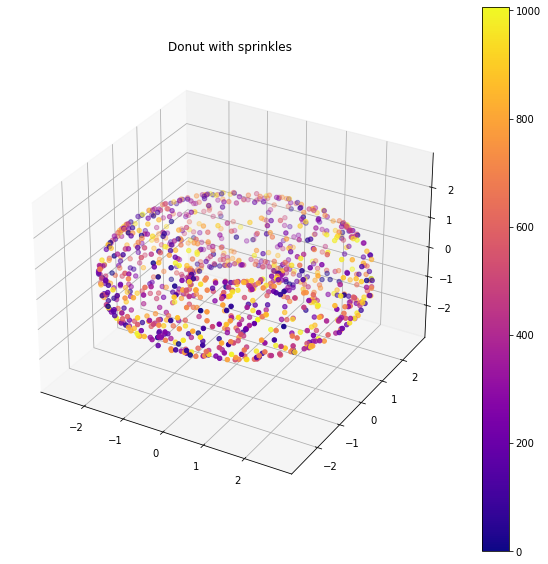

In [42]:
plot_3d(X,list(range(len(X))),"Donut with sprinkles",colorbar = True)

Hurrah! Our donut is intact, and our plotting function is working as expected.

Now let's visualize some diffusions, under various kernels.

## The Adaptive Kernel

Here we have the adaptive kernel born Diffusion matrix, and we visualize the diffusion centered on the point (0,-3,0), which (from the view of the plot below), should be on the outer rim of the torus, facing us directly.

In [ ]:
P = DiffusionMatrix(X,kernel_type="adaptive",k=20)

Distance to kth neighbors [0.59708883 0.67909704 0.60023527 ... 0.67545593 0.68828263 0.59838388]


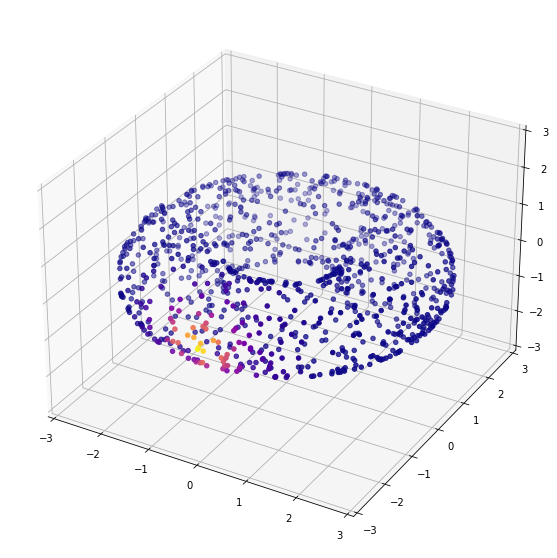

In [ ]:
dist = P[0]
plot_3d(X,dist)

## The Adaptive Anisotropic Kernel

Now we'll add one more round of density normalization with the "adaptive anisotropic" kernel:
$$ W_{a} = D^{-1} W D^{-1} $$
Where D is the matrix whose diagonals are the rowsums of W.

In [ ]:
P = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)

Distance to kth neighbors [0.59708883 0.67909704 0.60023527 ... 0.67545593 0.68828263 0.59838388]


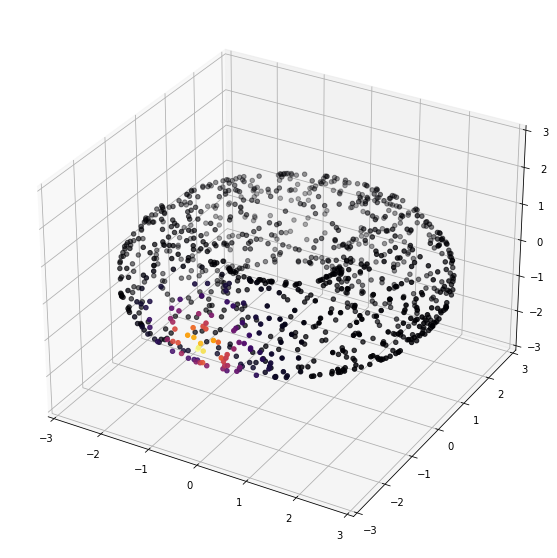

In [ ]:
dist = P[0]
plot_3d(X,dist)

It looks much the same, as expected. Ideally, this kernel will combat density related differences in the curvature, by equalizing the density.